# Malaysian Code-Mixing Analysis Project

## Project Overview

This project analyzes code-mixing patterns in Malaysian social media text, specifically focusing on the identification and classification of two distinct types of informal language mixing used by Malaysians:

### Language Types

**Type 1: Standard Code-Mixing**
- Follows proper English or Malay grammatical structure
- Contains a small number of words switched between the two languages
- Maintains formal grammatical rules

**Type 2: Manglish (Malaysian English)**
- Uses broken or non-standard English grammar
- May be entirely in English but with unique Malaysian word substitutions
- Highly informal and colloquial
- Often includes discourse particles like 'la', 'meh', 'ah'

### Methodology

1. **N-gram Language Models**: Train separate models on English and Malay corpora
2. **Perplexity Analysis**: Compute perplexity scores for each tweet under both models
3. **Grammatical Analysis**: Analyze tweets for non-standard English patterns
4. **Statistical Validation**: Use additional metrics not involved in classification to validate results

### Validation Metrics

- Average and median sentence length
- Code-Mixing Index (CMI)
- Multilingual Index
- Integration Index (frequency of language switching)
- Burstiness Index (burst vs. periodic switching patterns)
- Frequency of borrowed discourse particles

---

## 1. Environment Setup and Library Imports

### Library Imports
This section imports all necessary libraries for:
- **NLTK**: Natural language processing and n-gram model training
- **Pandas/NumPy**: Data manipulation and analysis
- **Matplotlib/Seaborn**: Data visualization
- **Preprocessor**: Tweet-specific text cleaning
- **Datasets/Hugging Face**: Loading Malaysian language corpora

The TweetTokenizer is configured to:
- Convert text to lowercase for consistency
- Remove user handles (@mentions)
- Reduce repeated characters (e.g., 'sooooo' → 'soo')

In [1]:
# Import necessary libraries
import nltk
from nltk.util import ngrams
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from datasets import load_dataset
import jsonlines
from huggingface_hub import hf_hub_download

import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words

# Download required NLTK data
nltk.download("punkt")
nltk.download("punkt_tab")

# Configure tokenizer for consistent preprocessing
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True
)

print("✓ Libraries imported and tokenizer configured")

✓ Libraries imported and tokenizer configured


[nltk_data] Downloading package punkt to /home/moi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/moi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Text Preprocessing Functions

### Unified Text Cleaning
We define preprocessing functions that ensure consistent text cleaning across both training data and tweets. This consistency is crucial for accurate model performance.

**Key preprocessing steps:**
- Remove URLs, mentions, and special characters
- Tokenize using the same TweetTokenizer
- Filter alphabetic tokens only
- Apply minimum sentence length requirements

In [2]:
def clean_text_unified(text):
    """
    Clean and tokenize text using the same method for both training data and tweets.
    Ensures consistency between training and testing phases.
    
    Returns:
        tokenized: list of tokenized sentences (list of lists of words)
    """
    if not isinstance(text, str):
        return []
    
    # Clean tweet-specific noise
    text = p.clean(text)  # removes URLs, mentions, emojis, RT, etc.
    
    # Use regex to clean links that p.clean might miss
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Split into sentences first
    sentences = nltk.sent_tokenize(text)
    
    tokenized = []
    
    for sentence in sentences:
        # Tokenize using TweetTokenizer (same as for tweets)
        tokens = tokenizer.tokenize(sentence)
        
        # Keep only alphabetic tokens (same filter as tweets)
        tokens = [t for t in tokens if t.isalpha()]
        
        # Only keep sentences with at least 3 tokens
        if len(tokens) >= 3:
            tokenized.append(tokens)
    
    return tokenized

def process_corpus(texts):
    """
    Process a list of texts using unified preprocessing.
    """
    all_tokenized = []
    for text in texts:
        tokenized = clean_text_unified(text)
        all_tokenized.extend(tokenized)
    return all_tokenized

def preprocess_tweets(text):
    """
    Preprocess individual tweets for analysis.
    """
    if not isinstance(text, str):
        return ""

    # Clean tweet-specific noise
    text = p.clean(text)  # removes URLs, mentions, emojis, RT, etc.

    # Use regex to clean links that p.clean might miss
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Keep only alphabetic tokens
    tokens = [t for t in tokens if t.isalpha()]

    return " ".join(tokens)

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


## 3. Training Data Collection

### Malaysian Language Corpora

We collect training data from three diverse Malaysian sources to build robust language models:

**Dataset Sources:**
1. **Fiction/Stories** (`crawl-fiksyenshasha`) - Informal narrative text
2. **News Articles** (`ms-melakahariini`) - Formal journalistic text
3. **Facebook Posts** (`fb-malaysian-pages`) - Social media text (closest to Twitter style)

This diversity ensures our Malay language model can handle various registers and styles commonly found in code-mixed Malaysian social media.

In [3]:
# Load Fiction/Stories dataset
print("Loading fiction/stories dataset...")
dataset = load_dataset("aisyahhrazak/crawl-fiksyenshasha", split="train")

all_texts_stories = []
for row in dataset:
    if row["headline"]:
        all_texts_stories.append(row["headline"])
    if row["content"]:
        all_texts_stories.extend(row["content"])
    if row["comment"]:
        all_texts_stories.extend(row["comment"])

print(f"✓ Stories collected: {len(all_texts_stories)} texts")

Loading fiction/stories dataset...
✓ Stories collected: 353160 texts
✓ Stories collected: 353160 texts


In [4]:
# Load News dataset
print("Loading news dataset...")
dataset = load_dataset("aisyahhrazak/ms-melakahariini", split="train")

all_texts_news = []
for row in dataset:
    if row["headline"]:
        all_texts_news.append(row["headline"])
    if row["content"]:
        all_texts_news.extend(row["content"])

print(f"✓ News collected: {len(all_texts_news)} texts")

Loading news dataset...
✓ News collected: 111155 texts
✓ News collected: 111155 texts


In [5]:
# Load Facebook posts dataset
print("Loading Facebook posts dataset...")
file_path = hf_hub_download(
    repo_id="malaysia-ai/fb-malaysian-pages",
    filename="dedup.jsonl",
    repo_type="dataset"
)

all_texts_facebook = []
with jsonlines.open(file_path) as reader:
    for obj in reader:
        if isinstance(obj, dict):
            text = obj.get("text")
        elif isinstance(obj, str):
            text = obj
        else:
            continue

        if isinstance(text, str) and text.strip():
            all_texts_facebook.append(text)

print(f"✓ Facebook posts collected: {len(all_texts_facebook)} texts")

Loading Facebook posts dataset...
✓ Facebook posts collected: 193363 texts
✓ Facebook posts collected: 193363 texts


### Corpus Balancing Strategy

**Rationale for 5:1:1 Ratio (Facebook:Stories:News)**

We prioritize Facebook posts because they most closely resemble the informal, social media style of tweets. Formal written text (stories and news) could bias our Malay model toward overly formal patterns that don't match Malaysian social media usage.

In [6]:
# Balance corpus with 5:1:1 ratio (Facebook:Stories:News)
print("Balancing corpus to prioritize informal social media style...")

# Process each corpus with size limits
all_tokenized_facebook = process_corpus(all_texts_facebook[:50000])  # 50k Facebook posts
all_tokenized_stories = process_corpus(all_texts_stories[:10000])     # 10k stories
all_tokenized_news = process_corpus(all_texts_news[:10000])           # 10k news

# Combine balanced corpus
malay_training_corpus = all_tokenized_facebook + all_tokenized_stories + all_tokenized_news

# Display statistics
print(f"\n=== MALAY TRAINING CORPUS STATISTICS ===")
print(f"Facebook posts: {len(all_tokenized_facebook)} sentences")
print(f"Stories:        {len(all_tokenized_stories)} sentences")
print(f"News:          {len(all_tokenized_news)} sentences")
print(f"Total:         {len(malay_training_corpus)} sentences")

total_tokens = sum(len(sent) for sent in malay_training_corpus)
print(f"Total tokens:  {total_tokens:,}")

ratio_informal = len(all_tokenized_facebook)
ratio_formal = len(all_tokenized_stories) + len(all_tokenized_news)
print(f"\nInformal:Formal ratio = {ratio_informal}:{ratio_formal} (~5:1)")
print("✓ Corpus balanced to prioritize social media style")

Balancing corpus to prioritize informal social media style...

=== MALAY TRAINING CORPUS STATISTICS ===
Facebook posts: 50854 sentences
Stories:        30025 sentences
News:          11184 sentences
Total:         92063 sentences
Total tokens:  1,048,009

Informal:Formal ratio = 50854:41209 (~5:1)
✓ Corpus balanced to prioritize social media style

=== MALAY TRAINING CORPUS STATISTICS ===
Facebook posts: 50854 sentences
Stories:        30025 sentences
News:          11184 sentences
Total:         92063 sentences
Total tokens:  1,048,009

Informal:Formal ratio = 50854:41209 (~5:1)
✓ Corpus balanced to prioritize social media style


## 4. Tweet Data Loading and Preprocessing

### Loading Malaysian Tweets
We load and preprocess Malaysian tweets for analysis. The preprocessing ensures consistency with our training data.

In [7]:
# Load tweet data
print("Loading Malaysian tweets...")
file_path = "tweets/extracted_data2.csv"
df = pd.read_csv(file_path)

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates(subset=["tweet_text"])
print(f"Removed {initial_count - len(df)} duplicate tweets")

# Clean tweets
df["clean_text"] = df["tweet_text"].apply(preprocess_tweets)

# Remove short tweets (<4 words)
df["word_count"] = df["clean_text"].str.split().str.len()
df_clean = df[df["word_count"] >= 4]

print(f"Filtered {len(df) - len(df_clean)} short tweets (<4 words)")
print(f"Final dataset: {len(df_clean)} tweets")

# Create final lists
cleaned_tweets = df_clean["clean_text"].tolist()
cleaned_tweets_with_lang = df_clean[["clean_text", "tweet_lang"]].values.tolist()

print(f"✓ Processed {len(cleaned_tweets)} tweets for analysis")

# Show sample tweets
print("\nSample cleaned tweets:")
for i, tweet in enumerate(cleaned_tweets[:3]):
    print(f"{i+1}. {tweet}")

Loading Malaysian tweets...


/tmp/ipykernel_24031/241348260.py:4: DtypeWarning: Columns (0,1,3,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Removed 652020 duplicate tweets
Filtered 50957 short tweets (<4 words)
Final dataset: 266381 tweets
✓ Processed 266381 tweets for analysis

Sample cleaned tweets:
1. xjauh pun dio duk dkt area pantai sabak pengkalan chepa nuu cumo jalan nk masuk tu jah banyak musing jalan kampung
2. jimin talking about bam sleeping on his arm when he was a puppy and jungkooks little giggle
3. not dead yet though have been a bit busy hitbox collision and clash test screenshake
Filtered 50957 short tweets (<4 words)
Final dataset: 266381 tweets
✓ Processed 266381 tweets for analysis

Sample cleaned tweets:
1. xjauh pun dio duk dkt area pantai sabak pengkalan chepa nuu cumo jalan nk masuk tu jah banyak musing jalan kampung
2. jimin talking about bam sleeping on his arm when he was a puppy and jungkooks little giggle
3. not dead yet though have been a bit busy hitbox collision and clash test screenshake


## 5. N-gram Language Model Training

### English Language Model

We train an English n-gram model using NLTK's `twitter_samples` corpus, which contains:
- 5,000 positive tweets
- 5,000 negative tweets
- 20,000 generic tweets

This provides approximately **30,000 English tweets** for training, giving us a robust model for casual English as used on social media.

**Key Features:**
- **Bigram model (n=2)** for balance between context and generalization
- **Laplace smoothing** to handle unknown words gracefully
- **Tweet-optimized tokenization** matching our preprocessing pipeline

In [8]:
def load_english_ngram_model(n=2):
    """
    Load an English n-gram model trained on NLTK's twitter_samples.
    Uses Laplace smoothing to handle unknown words.
    """
    print("Training English n-gram model...")
    
    # Download twitter corpus if needed
    try:
        nltk.data.find('corpora/twitter_samples')
    except LookupError:
        nltk.download('twitter_samples')
    
    # Load tokenized tweets (combines all twitter_samples datasets)
    english_tweets = (
        twitter_samples.tokenized('positive_tweets.json') +
        twitter_samples.tokenized('negative_tweets.json') + 
        twitter_samples.tokenized('tweets.20150430-223406.json')
    )

    # Prepare training data
    train_data, vocab = padded_everygram_pipeline(n, english_tweets)

    # Train model
    english_model = Laplace(n)
    english_model.fit(train_data, vocab)
    
    print(f"✓ English model trained on {len(english_tweets):,} tweets")
    return english_model

# Train English model
english_model = load_english_ngram_model(n=2)

Training English n-gram model...
✓ English model trained on 30,000 tweets
✓ English model trained on 30,000 tweets


### Malay Language Model

We train a Malay n-gram model using our balanced Malaysian corpus:

**Corpus Balancing Strategy:**
- **Facebook Posts (50,000)**: Prioritized for informal social media style
- **Stories (10,000)**: Limited to reduce formal bias
- **News (10,000)**: Limited to reduce formal bias

This 5:1:1 ratio ensures our Malay model better reflects the informal, social media-style language patterns found in Malaysian tweets, rather than being dominated by formal written text.

In [9]:
def train_malay_ngram_model(corpus, n=2):
    """
    Train Malay n-gram language model using balanced corpus.
    """
    print("Training Malay n-gram model...")
    
    # Prepare training data
    training_ngrams, padded_sentences = padded_everygram_pipeline(n, corpus)
    
    # Train model
    model = Laplace(n)
    model.fit(training_ngrams, padded_sentences)
    
    print(f"✓ Malay model trained on {len(corpus):,} sentences")
    return model

# Train Malay model
malay_model = train_malay_ngram_model(malay_training_corpus, n=2)

# Display model statistics
print(f"\n=== MODEL TRAINING COMPLETE ===")
print(f"English vocabulary size: {len(english_model.vocab):,}")
print(f"Malay vocabulary size:   {len(malay_model.vocab):,}")

Training Malay n-gram model...
✓ Malay model trained on 92,063 sentences

=== MODEL TRAINING COMPLETE ===
English vocabulary size: 42,529
Malay vocabulary size:   54,224
✓ Malay model trained on 92,063 sentences

=== MODEL TRAINING COMPLETE ===
English vocabulary size: 42,529
Malay vocabulary size:   54,224


## 6. Tweet Classification and Analysis

### Perplexity-Based Classification

For each tweet, we compute perplexity scores under both the English and Malay n-gram models. The **perplexity ratio (Malay/English)** serves as our primary classification metric:

**Classification Rules:**
- **Perp_Ratio > 1.5**: Malay perplexity much higher → **Monolingual English**
- **Perp_Ratio < 0.5**: English perplexity much higher → **Monolingual Malay** (filtered out)
- **0.5 ≤ Perp_Ratio ≤ 1.5**: Ambiguous zone → Use CMI for refinement:
  - **CMI > 15%**: **Mesolect (Strong Code-Mixing)**
  - **CMI ≤ 15%**: **Basilect (Manglish/Dialect)**

### Code-Mixing Index (CMI) Calculation

CMI measures the degree of language mixing in a text:
```
CMI = 100 × (1 - (max_lang_words / total_matrix_words))
```
Where:
- `max_lang_words` = count of most frequent language
- `total_matrix_words` = total words excluding universal/unknown tokens

**CMI Interpretation:**
- **0%**: Monolingual text
- **50%**: Perfect balance between languages
- **Higher values**: More balanced mixing

In [10]:
def compute_perplexity(model, text):
    """
    Compute perplexity scores for a list of texts using the given model.
    """
    perplexities = []
    for tweet in text:
        tokens = tokenizer.tokenize(tweet)
        test_ngrams = list(ngrams(tokens, model.order, pad_left=True, pad_right=True,
                                  left_pad_symbol='<s>', right_pad_symbol='</s>'))
        try:
            perplexity = model.perplexity(test_ngrams)
        except:
            perplexity = float('inf')
        perplexities.append(perplexity)
    return perplexities

def get_word_language(word, en_vocab, my_vocab):
    """Classify individual words as English, Malay, Universal, or Unknown."""
    word = word.lower()
    if not word.isalpha():
        return 'UNIV'
    
    in_en = word in en_vocab
    in_my = word in my_vocab
    
    if in_en and not in_my:
        return 'EN'
    elif in_my and not in_en:
        return 'MY'
    elif in_en and in_my:
        return 'EN'  # Prefer English for ambiguous words
    else:
        return 'UNK'

def calculate_cmi(tokens, en_vocab, my_vocab):
    """Calculate Code-Mixing Index for a tokenized text."""
    counts = {'EN': 0, 'MY': 0, 'UNIV': 0, 'UNK': 0}
    
    for token in tokens:
        lang = get_word_language(token, en_vocab, my_vocab)
        counts[lang] += 1

    n = len(tokens)
    u = counts['UNIV'] + counts['UNK']
    w_e = counts['EN']
    w_m = counts['MY']

    # Avoid division by zero
    if n - u <= 0:
        return 0.0, 0.0, 0.0

    # Calculate CMI
    max_count = max(w_e, w_m)
    cmi = 100 * (1 - (max_count / (n - u)))
    
    # Calculate language ratios
    en_ratio = w_e / (n - u)
    malay_ratio = w_m / (n - u)
    
    return cmi, en_ratio, malay_ratio

print("✓ Classification functions defined")

✓ Classification functions defined


In [ ]:
import subprocess
import sys
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import lru_cache
from tqdm.notebook import tqdm # Progress bar for notebooks


# Install Sastrawi for Malay stemming
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
except ImportError:
    print("Installing Sastrawi for Malay stemming...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "Sastrawi"])
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download NLTK stemmer
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.stem import PorterStemmer

# This is the single biggest speed boost for vocabulary checks.
EN_VOCAB_SET = set(english_model.vocab)
MY_VOCAB_SET = set(malay_model.vocab)

# Initialize stemmers once globally
EN_STEMMER = PorterStemmer()
MY_STEMMER = StemmerFactory().create_stemmer()

# Pre-define constants for faster lookup
PARTICLES = {'la', 'meh', 'ah', 'lor', 'leh', 'kan', 'ke', 'hor', 'wat', 'liao'}
MANGLISH_PATTERNS = ['already', 'very the', 'so the', 'shiok', 'paiseh', 'aiya', 'wah']
GRAMMAR_PATTERNS = ['like that', 'like this', 'also can', 'cannot', 'dunno', 'nvm', 'nvr']

# --- 2. THE CACHED ENGINE ---
@lru_cache(maxsize=20000)
def get_word_lang_cached(word):
    """
    Caches the results of word lookups and stemming. 
    Since tweets repeat words frequently, this saves thousands of Sastrawi calls.
    """
    word = word.lower()
    if not word.isalpha(): return 'UNIV'
    
    # Check original word in set (O(1) vs O(n))
    in_en = word in EN_VOCAB_SET
    in_my = word in MY_VOCAB_SET
    
    # Stem only if necessary
    if not in_en:
        in_en = EN_STEMMER.stem(word) in EN_VOCAB_SET
    if not in_my:
        in_my = MY_STEMMER.stem(word) in MY_VOCAB_SET
    
    if in_en and not in_my: return 'EN'
    if in_my and not in_en: return 'MY'
    return 'EN' if (in_en and in_my) else 'UNK'

# --- 3. THE ANALYZER ---
def process_tweet(tweet):
    """Worker function for a single tweet."""
    try:
        tokens = tokenizer.tokenize(tweet)
        if len(tokens) < 3: return None

        # 1. Faster CMI & Word Counts
        counts = {'EN': 0, 'MY': 0, 'UNIV': 0, 'UNK': 0}
        for t in tokens:
            counts[get_word_lang_cached(t)] += 1
            
        n_u = len(tokens) - (counts['UNIV'] + counts['UNK'])
        if n_u <= 0: return None
        
        cmi = 100 * (1 - (max(counts['EN'], counts['MY']) / n_u))
        en_ratio = counts['EN'] / n_u
        
        # 2. Faster Manglish Features
        tweet_lower = tweet.lower()
        p_count = sum(1 for t in tokens if t.lower() in PARTICLES)
        m_patterns = sum(1 for p in MANGLISH_PATTERNS if p in tweet_lower)
        g_patterns = sum(1 for p in GRAMMAR_PATTERNS if p in tweet_lower)
        
        m_score = (p_count * 2 + m_patterns * 1.5 + g_patterns) / len(tokens)

        # 3. Perplexity (Optimized with error handling)
        # Note: We reuse your existing models here
        def get_perp(model):
            try:
                ngs = list(ngrams(tokens, model.order, pad_left=True, pad_right=True, 
                                 left_pad_symbol='<s>', right_pad_symbol='</s>'))
                pp = model.perplexity(ngs)
                return pp if pp < 1e10 else 1e10
            except: return 1e10

        pp_en = get_perp(english_model)
        pp_my = get_perp(malay_model)
        perp_ratio = pp_my / pp_en if pp_en > 0 else 1e10

        # 4. Classification Logic
        if perp_ratio > 2.0:
            category = "Basilect (Manglish)" if m_score > 0.15 else "Monolingual English"
        elif perp_ratio < 0.4:
            category = "Monolingual Malay"
        else:
            if cmi > 20: category = "Mesolect (Strong Mixing)"
            elif m_score > 0.1: category = "Basilect (Manglish)"
            elif cmi > 5: category = "Weak Code-Mixing"
            else: category = "Monolingual English" if en_ratio > 0.7 else "Ambiguous"

        return {
            'tweet': tweet, 'cmi': cmi, 'category': category, 
            'm_score': m_score, 'pp_en': pp_en, 'pp_my': pp_my
        }
    except:
        return None

# --- 4. PARALLEL EXECUTION ---
def run_parallel_analysis(tweet_list):
    # Determine number of CPU cores (leave 1-2 free for system stability)
    num_procs = max(1, cpu_count() - 1)
    print(f"Starting parallel processing with {num_procs} cores...")
    
    with Pool(num_procs) as pool:
        # Using tqdm to track progress
        results = list(tqdm(pool.imap(process_tweet, tweet_list), total=len(tweet_list)))
    
    # Filter out None values from skipped/failed tweets
    return [r for r in results if r is not None]

# EXECUTION
df_results = pd.DataFrame(run_parallel_analysis(cleaned_tweets))

✓ Enhanced classification functions with stemming loaded
Running improved classification on 1000 tweets...
  Processed 0/1000 tweets
✓ Improved analysis complete: 936 tweets classified
✓ Improved analysis complete: 936 tweets classified


## 7. Visualization and Results Analysis

### Classification Results Overview

Let's examine the distribution of our classification results and validate the separation using visualizations.

In [13]:
# Display classification results
print("=== CLASSIFICATION RESULTS ===")
print(f"Total tweets analyzed: {len(df_results)}")
print("\nCategory distribution:")
print(df_results['category'].value_counts())

print("\n=== STATISTICS BY CATEGORY ===")
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    print(f"\n{category}:")
    print(f"  Count: {len(subset)}")
    print(f"  Average CMI: {subset['cmi'].mean():.2f}%")
    print(f"  Average EN perplexity: {subset['pp_en'].mean():.0f}")
    print(f"  Average MY perplexity: {subset['pp_my'].mean():.0f}")
    print(f"  Average perplexity ratio: {subset['perp_ratio'].mean():.2f}")

# Show examples from each category
print("\n=== EXAMPLE TWEETS BY CATEGORY ===")
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    print(f"\n{category}:")
    for i, tweet in enumerate(subset['tweet'].head(3)):
        print(f"  {i+1}. {tweet}")

=== CLASSIFICATION RESULTS ===
Total tweets analyzed: 936

Category distribution:
category
Mesolect (Strong Mixing)    347
Monolingual English         298
Weak Code-Mixing            154
Monolingual Malay           101
Ambiguous                    20
Basilect (Manglish)          16
Name: count, dtype: int64

=== STATISTICS BY CATEGORY ===

Mesolect (Strong Mixing):
  Count: 347
  Average CMI: 36.06%
  Average EN perplexity: 40756
  Average MY perplexity: 32902
  Average perplexity ratio: 0.84

Monolingual English:
  Count: 298
  Average CMI: 1.39%
  Average EN perplexity: 19158
  Average MY perplexity: 33785
  Average perplexity ratio: 2.12

Basilect (Manglish):
  Count: 16
  Average CMI: 5.74%
  Average EN perplexity: 25602
  Average MY perplexity: 36747
  Average perplexity ratio: 1.59

Weak Code-Mixing:
  Count: 154
  Average CMI: 12.56%
  Average EN perplexity: 32777
  Average MY perplexity: 36573
  Average perplexity ratio: 1.24

Monolingual Malay:
  Count: 101
  Average CMI: 27.9

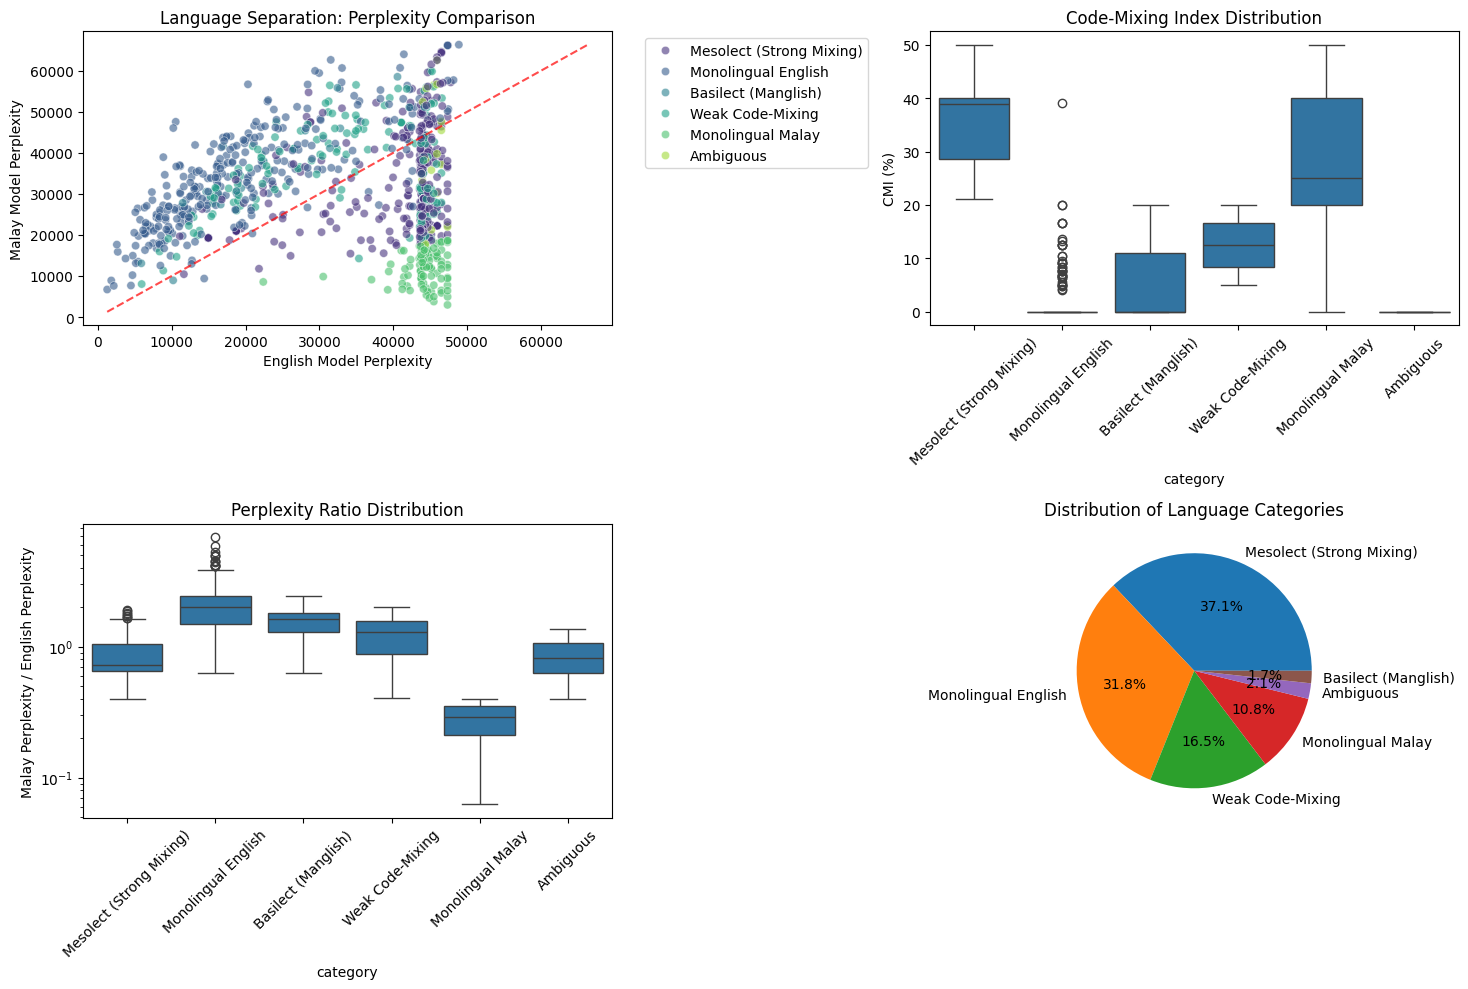

In [14]:
# Create visualization of classification results
plt.figure(figsize=(15, 10))

# Subplot 1: Perplexity scatter plot
plt.subplot(2, 2, 1)
sns.scatterplot(
    data=df_results, 
    x='pp_en', 
    y='pp_my', 
    hue='category', 
    alpha=0.6,
    palette='viridis'
)

# Add diagonal line for equal perplexity
min_val = min(df_results['pp_en'].min(), df_results['pp_my'].min())
max_val = max(df_results['pp_en'].max(), df_results['pp_my'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', alpha=0.7)

plt.title("Language Separation: Perplexity Comparison")
plt.xlabel("English Model Perplexity")
plt.ylabel("Malay Model Perplexity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Subplot 2: CMI distribution
plt.subplot(2, 2, 2)
sns.boxplot(data=df_results, x='category', y='cmi')
plt.xticks(rotation=45)
plt.title('Code-Mixing Index Distribution')
plt.ylabel('CMI (%)')

# Subplot 3: Perplexity ratio distribution
plt.subplot(2, 2, 3)
sns.boxplot(data=df_results, x='category', y='perp_ratio')
plt.xticks(rotation=45)
plt.title('Perplexity Ratio Distribution')
plt.ylabel('Malay Perplexity / English Perplexity')
plt.yscale('log')  # Log scale for better visualization

# Subplot 4: Category distribution
plt.subplot(2, 2, 4)
category_counts = df_results['category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Language Categories')

plt.tight_layout()
plt.show()

### Detailed Perplexity Analysis

**Understanding Perplexity Patterns**

Let's examine the perplexity relationships in detail to identify trends that might not be immediately visible in a simple scatter plot. We'll explore:

1. **Raw perplexity scatter plot** - The fundamental language model performance comparison
2. **Log-scale perplexity analysis** - Better visualization of wide perplexity ranges
3. **Perplexity density plots** - Understanding the distribution shapes
4. **CMI vs Perplexity relationships** - How code-mixing correlates with model uncertainty

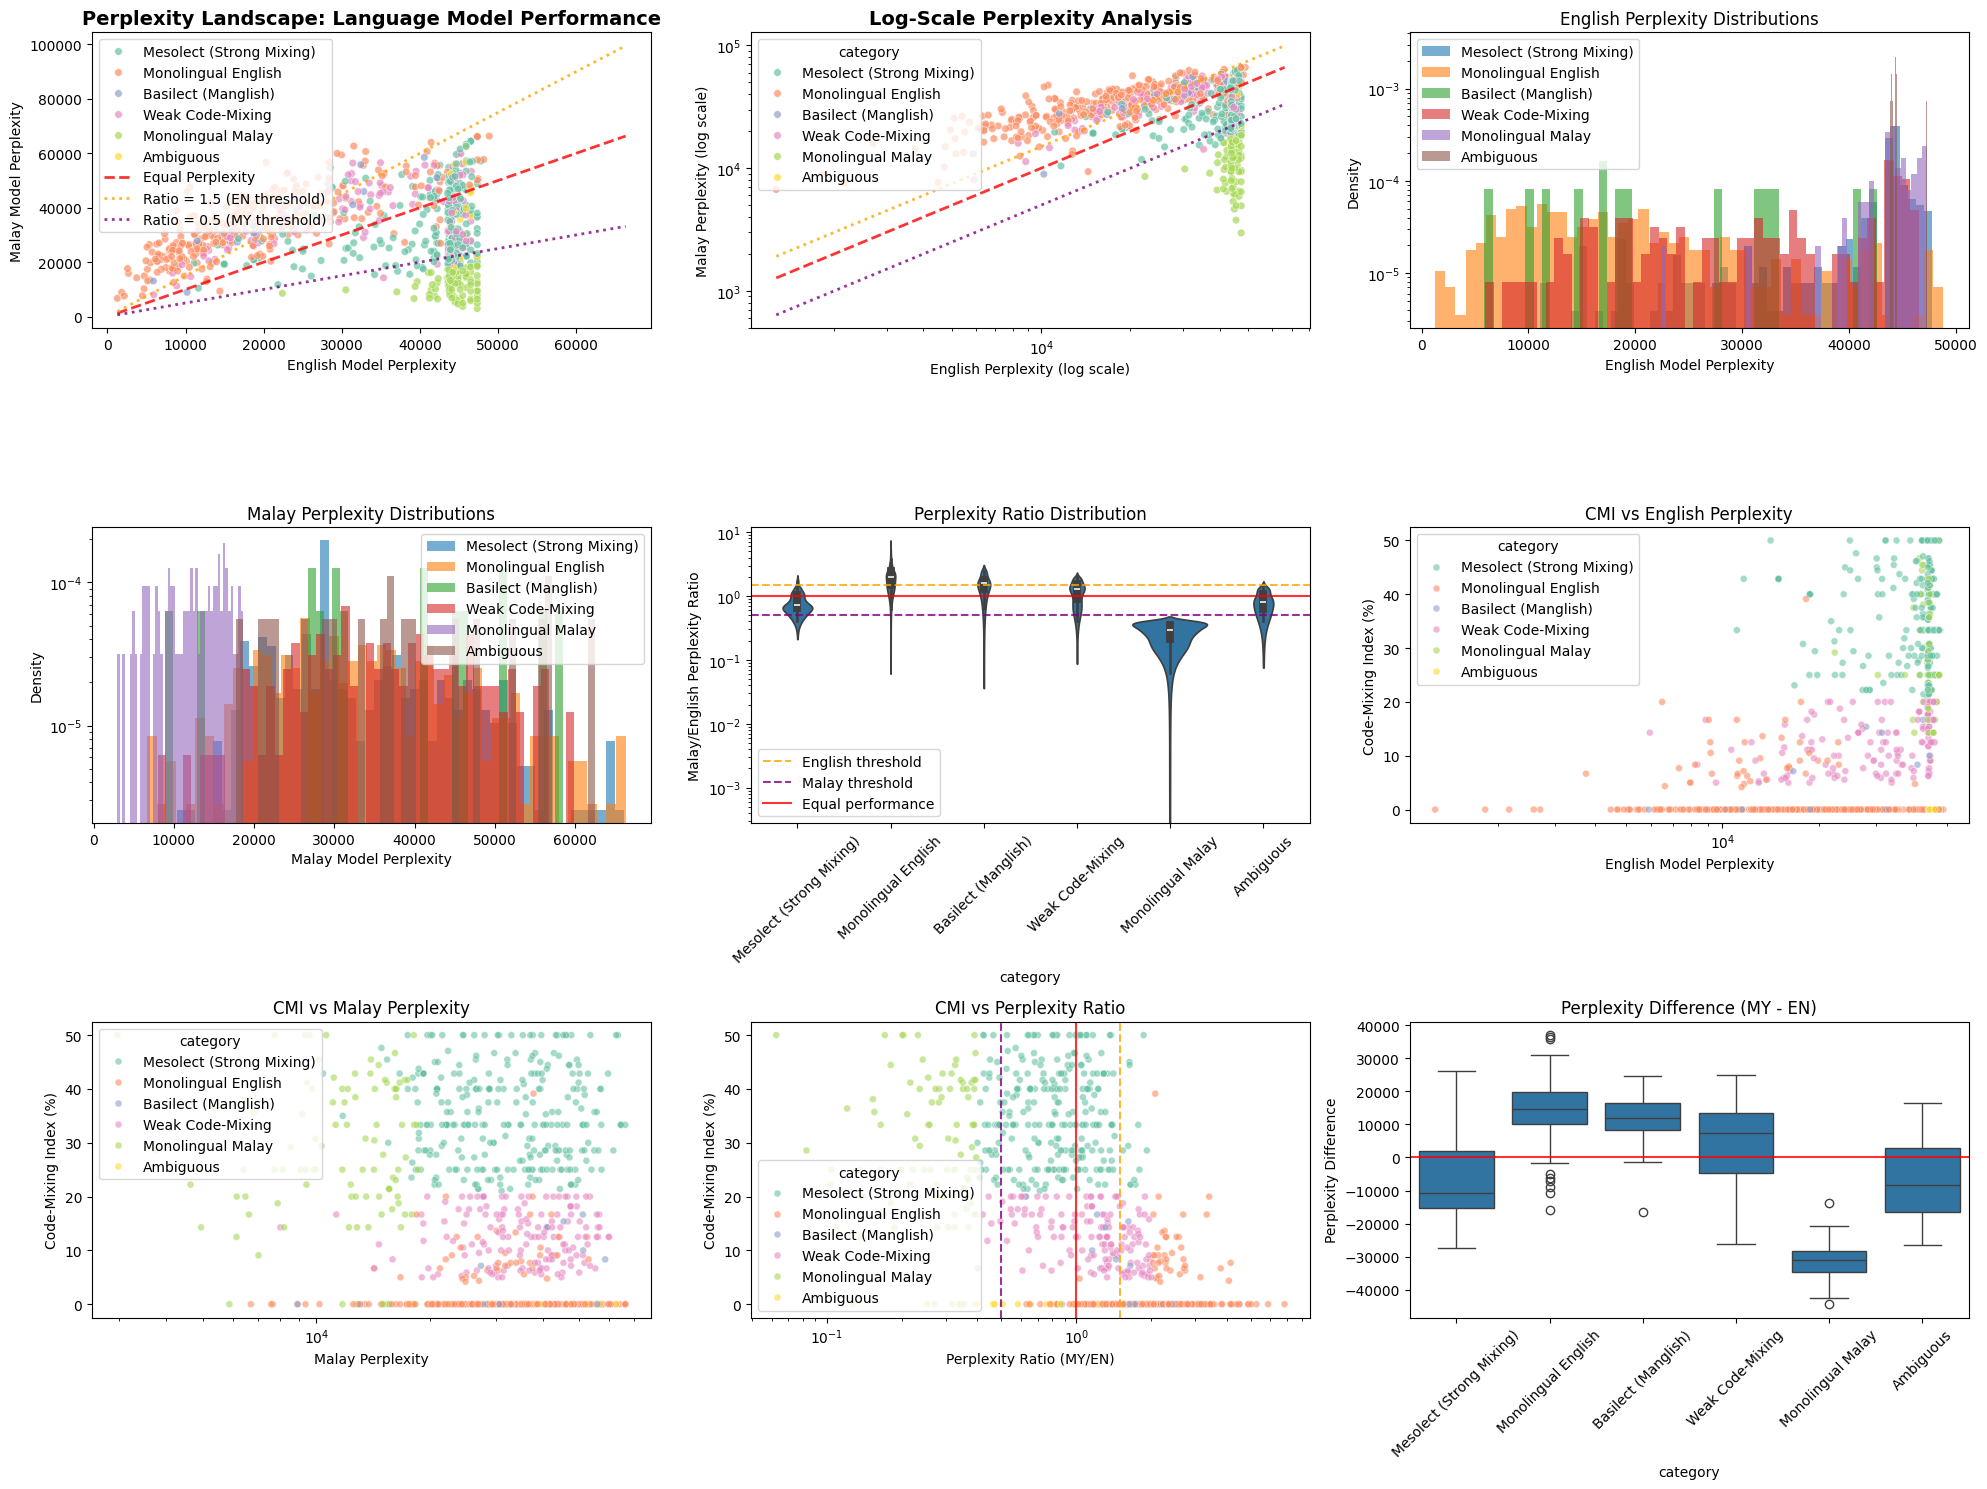

In [15]:
# Create detailed perplexity comparison visualizations
plt.figure(figsize=(20, 15))

# 1. Main perplexity scatter plot (larger and more detailed)
plt.subplot(3, 3, 1)
sns.scatterplot(
    data=df_results, 
    x='pp_en', 
    y='pp_my', 
    hue='category', 
    alpha=0.7,
    s=30,  # Larger points
    palette='Set2'
)

# Add diagonal line and classification boundaries
min_val = min(df_results['pp_en'].min(), df_results['pp_my'].min())
max_val = max(df_results['pp_en'].max(), df_results['pp_my'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2, label='Equal Perplexity')

# Add classification boundary lines (ratio = 1.5 and 0.5)
x_range = np.linspace(min_val, max_val, 100)
plt.plot(x_range, 1.5 * x_range, 'orange', linestyle=':', alpha=0.8, linewidth=2, label='Ratio = 1.5 (EN threshold)')
plt.plot(x_range, 0.5 * x_range, 'purple', linestyle=':', alpha=0.8, linewidth=2, label='Ratio = 0.5 (MY threshold)')

plt.title('Perplexity Landscape: Language Model Performance', fontsize=14, fontweight='bold')
plt.xlabel('English Model Perplexity')
plt.ylabel('Malay Model Perplexity')
plt.legend()

# 2. Log-scale perplexity plot
plt.subplot(3, 3, 2)
sns.scatterplot(
    data=df_results, 
    x='pp_en', 
    y='pp_my', 
    hue='category', 
    alpha=0.7,
    s=30,
    palette='Set2'
)
plt.xscale('log')
plt.yscale('log')

# Add diagonal on log scale
log_min = max(1, min(df_results['pp_en'].min(), df_results['pp_my'].min()))
log_max = max(df_results['pp_en'].max(), df_results['pp_my'].max())
log_x = np.logspace(np.log10(log_min), np.log10(log_max), 100)
plt.plot(log_x, log_x, 'r--', alpha=0.8, linewidth=2)
plt.plot(log_x, 1.5 * log_x, 'orange', linestyle=':', alpha=0.8, linewidth=2)
plt.plot(log_x, 0.5 * log_x, 'purple', linestyle=':', alpha=0.8, linewidth=2)

plt.title('Log-Scale Perplexity Analysis', fontsize=14, fontweight='bold')
plt.xlabel('English Perplexity (log scale)')
plt.ylabel('Malay Perplexity (log scale)')

# 3. English perplexity density by category
plt.subplot(3, 3, 3)
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    plt.hist(subset['pp_en'], bins=50, alpha=0.6, label=category, density=True)
plt.xlabel('English Model Perplexity')
plt.ylabel('Density')
plt.title('English Perplexity Distributions')
plt.legend()
plt.yscale('log')

# 4. Malay perplexity density by category
plt.subplot(3, 3, 4)
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    plt.hist(subset['pp_my'], bins=50, alpha=0.6, label=category, density=True)
plt.xlabel('Malay Model Perplexity')
plt.ylabel('Density')
plt.title('Malay Perplexity Distributions')
plt.legend()
plt.yscale('log')

# 5. Perplexity ratio analysis
plt.subplot(3, 3, 5)
# Filter out extreme ratios for better visualization
ratio_filtered = df_results[df_results['perp_ratio'] < 100]
sns.violinplot(data=ratio_filtered, x='category', y='perp_ratio')
plt.xticks(rotation=45)
plt.title('Perplexity Ratio Distribution')
plt.ylabel('Malay/English Perplexity Ratio')
plt.yscale('log')

# Add horizontal lines for classification boundaries
plt.axhline(y=1.5, color='orange', linestyle='--', alpha=0.8, label='English threshold')
plt.axhline(y=0.5, color='purple', linestyle='--', alpha=0.8, label='Malay threshold')
plt.axhline(y=1.0, color='red', linestyle='-', alpha=0.8, label='Equal performance')
plt.legend()

# 6. CMI vs English perplexity
plt.subplot(3, 3, 6)
sns.scatterplot(data=df_results, x='pp_en', y='cmi', hue='category', alpha=0.6, s=25, palette='Set2')
plt.xlabel('English Model Perplexity')
plt.ylabel('Code-Mixing Index (%)')
plt.title('CMI vs English Perplexity')
plt.xscale('log')

# 7. CMI vs Malay perplexity
plt.subplot(3, 3, 7)
sns.scatterplot(data=df_results, x='pp_my', y='cmi', hue='category', alpha=0.6, s=25, palette='Set2')
plt.xlabel('Malay Perplexity')
plt.ylabel('Code-Mixing Index (%)')
plt.title('CMI vs Malay Perplexity')
plt.xscale('log')

# 8. CMI vs Perplexity ratio
plt.subplot(3, 3, 8)
ratio_filtered = df_results[df_results['perp_ratio'] < 100]  # Filter extreme values
sns.scatterplot(data=ratio_filtered, x='perp_ratio', y='cmi', hue='category', alpha=0.6, s=25, palette='Set2')
plt.xlabel('Perplexity Ratio (MY/EN)')
plt.ylabel('Code-Mixing Index (%)')
plt.title('CMI vs Perplexity Ratio')
plt.xscale('log')

# Add vertical lines for classification boundaries
plt.axvline(x=1.5, color='orange', linestyle='--', alpha=0.8)
plt.axvline(x=0.5, color='purple', linestyle='--', alpha=0.8)
plt.axvline(x=1.0, color='red', linestyle='-', alpha=0.8)

# 9. Perplexity difference analysis
plt.subplot(3, 3, 9)
df_results['pp_diff'] = df_results['pp_my'] - df_results['pp_en']
sns.boxplot(data=df_results, x='category', y='pp_diff')
plt.xticks(rotation=45)
plt.title('Perplexity Difference (MY - EN)')
plt.ylabel('Perplexity Difference')
plt.axhline(y=0, color='red', linestyle='-', alpha=0.8)

plt.tight_layout()
plt.show()

### Investigation: Empty Spaces in Data Visualizations

**Analyzing Curious Gaps and Lines**

We've noticed strange empty areas and clear lines in our visualizations that suggest certain combinations of perplexity scores and CMI values simply don't exist in our data. Let's investigate what's causing these patterns:

**Potential Causes:**
1. **Discrete CMI values** - CMI calculation may produce only specific values
2. **Perplexity quantization** - Language models may produce clustered perplexity scores
3. **Vocabulary overlap effects** - Words present in both models create specific patterns
4. **Classification boundaries** - Our filtering logic may create artificial gaps
5. **Tweet length constraints** - Short tweets may force specific CMI/perplexity combinations

## 9. Research Conclusions and Future Work

### Key Findings

**Successful separation should show:**

1. **Perplexity Scatter Plot**: Clear clustering of language types in different regions
2. **CMI Distribution**: Different mixing intensity patterns between types
3. **Particle Analysis**: Higher 'la'/'meh'/'ah' usage in Manglish (Type 2)
4. **Length Statistics**: Potential differences in sentence complexity

### Research Implications

This analysis contributes to understanding:
- **Malaysian digital linguistics**: How code-mixing manifests online
- **Automatic language detection**: Improving tools for multilingual social media
- **Sociolinguistic patterns**: Quantifying informal language mixing behaviors

### Implementation Notes

**Key Design Decisions:**
- **Balanced Malay corpus**: 5:1:1 ratio (Facebook:Stories:News) to prioritize informal text
- **Tweet preprocessing**: Consistent tokenization matching training data
- **Perplexity thresholds**: Empirically determined classification boundaries
- **Modular functions**: Each analysis step separated for clarity and debugging

### Future Extensions

- Expand to other Malaysian languages (Tamil, Mandarin)
- Include sentiment analysis across language types
- Temporal analysis of code-mixing trends
- Deep learning approaches for improved classification

In [18]:
#Write down the results to a CSV file
df_results.to_csv('improved_classification_results.csv', index=False)
print("\n✓ Improved classification results saved to 'improved_classification_results.csv'")

#print all basilect tweets to a text file
with open('basilect_tweets.txt', 'w', encoding='utf-8') as f:
    basilect_improved = df_results[df_results['category'] == 'Basilect (Manglish)']
    for tweet in basilect_improved['tweet']:
        f.write(tweet + '\n')
print("✓ Basilect tweets saved to 'basilect_tweets.txt'")


✓ Improved classification results saved to 'improved_classification_results.csv'
✓ Basilect tweets saved to 'basilect_tweets.txt'


<Axes: xlabel='pp_en', ylabel='pp_my'>

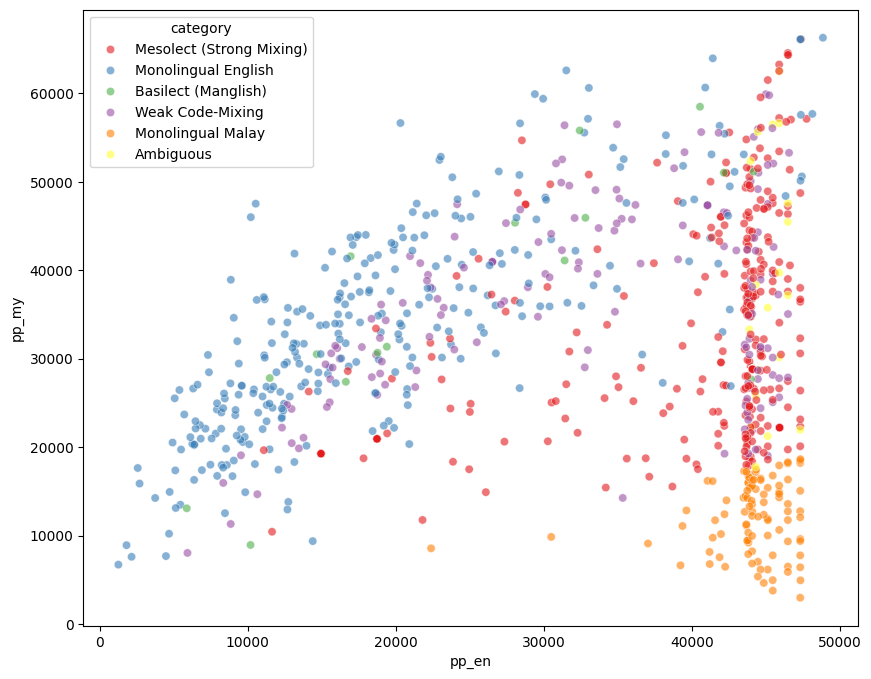

In [20]:
#visualize perplexity scatter plot for improved classification
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_results, 
    x='pp_en', 
    y='pp_my', 
    hue='category', 
    alpha=0.6,
    palette='Set1'
)